# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
import warnings
import cv2
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
%matplotlib inline
sns.set()

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.preprocessing.image import ImageDataGenerator

In [3]:
#
# Add your code here
#

from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
cd "/content/gdrive/MyDrive"

/content/gdrive/MyDrive


In [5]:
data_parent = '/content/gdrive/MyDrive/train_val'
print (os.listdir(data_parent))

['40_0_3_20170119183403621.jpg.chip.jpg', '75_0_0_20170117174511134.jpg.chip.jpg', '18_1_0_20170109213011914.jpg.chip.jpg', '70_1_3_20170116224931319.jpg.chip.jpg', '26_1_1_20170116232602440.jpg.chip.jpg', '23_0_1_20170114033532450.jpg.chip.jpg', '4_0_0_20170109191251137.jpg.chip.jpg', '1_1_4_20161221192615380.jpg.chip.jpg', '28_0_2_20170107212142294.jpg.chip.jpg', '72_1_0_20170110182012800.jpg.chip.jpg', '26_1_1_20170113011732808.jpg.chip.jpg', '34_0_1_20170113135659457.jpg.chip.jpg', '25_0_0_20170117195027938.jpg.chip.jpg', '3_1_4_20170103205816397.jpg.chip.jpg', '54_0_3_20170119210214520.jpg.chip.jpg', '45_0_3_20170119201303715.jpg.chip.jpg', '13_0_2_20170103201143159.jpg.chip.jpg', '24_1_3_20170104222753607.jpg.chip.jpg', '4_0_0_20170110213211374.jpg.chip.jpg', '56_1_0_20170110122842545.jpg.chip.jpg', '27_0_1_20170117010749619.jpg.chip.jpg', '37_1_3_20170119202521964.jpg.chip.jpg', '8_0_2_20170103175549207.jpg.chip.jpg', '32_1_1_20170112213704768.jpg.chip.jpg', '26_0_2_201701162104

##Exploratory Data Analysis


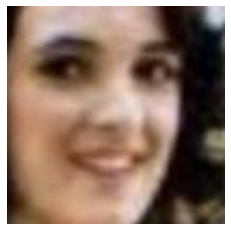

In [11]:
from PIL import Image
img = Image.open(df['image'][50])
plt.axis('off')
plt.imshow(img);


##Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the train_val/ folder to have a first impression of the dataset. You may also check what the size of the images are.

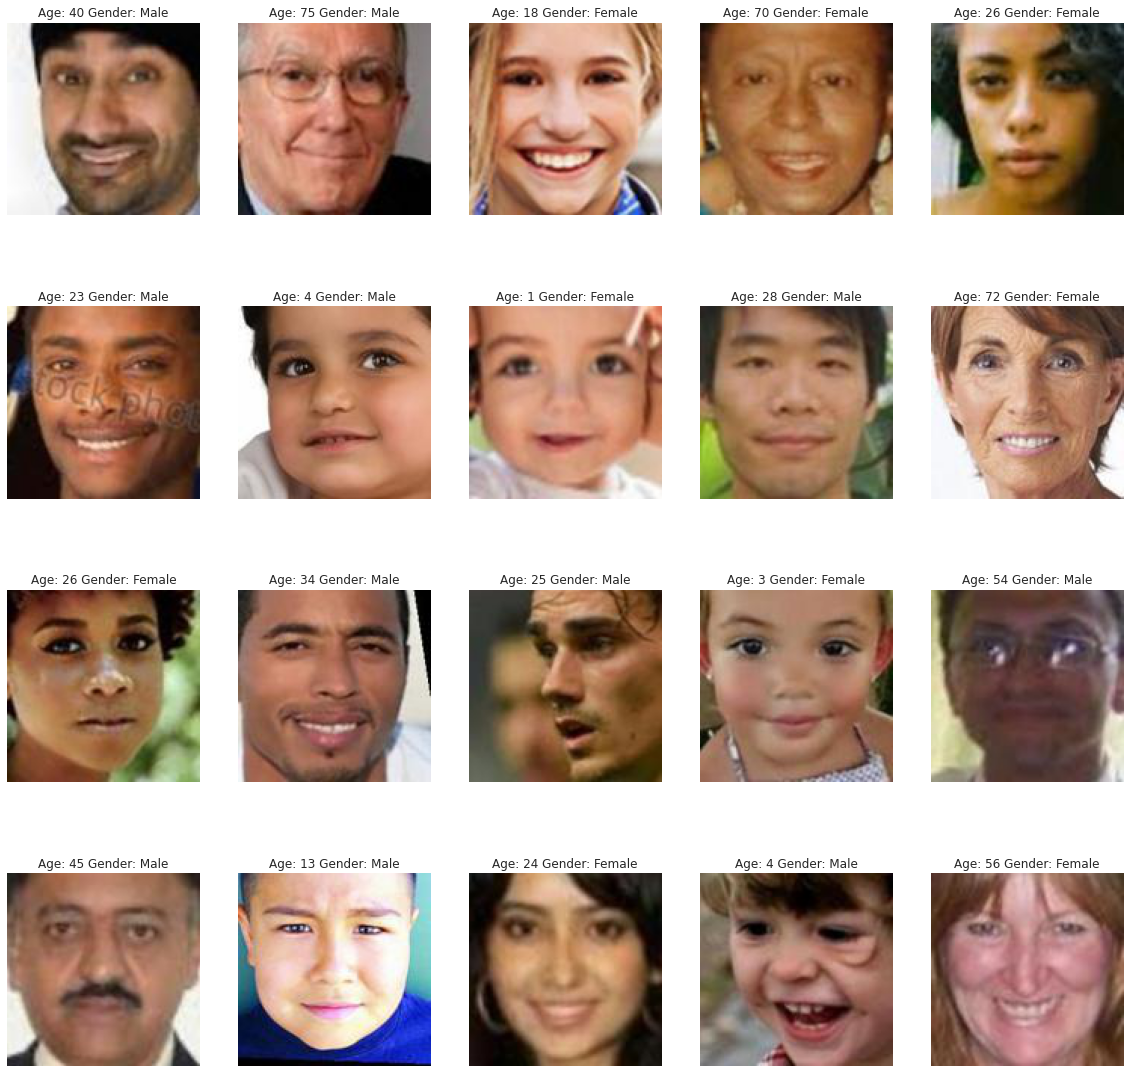

In [10]:
#
# Add your code here
#

plt.figure(figsize =(20, 20))
files = df.iloc[0:20]

for index, file, age, gender in files.itertuples():
  plt.subplot(4, 5, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
  plt.axis('off')

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [6]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(data_parent)):
  image_path = os.path.join(data_parent, filename)
  temp = filename.split('_')
  age = int(temp[0])
  gender = int(temp[1])
  image_paths.append(image_path)
  age_labels.append(age)
  gender_labels.append(gender)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [7]:
df = pd.DataFrame()
df ['image'], df['age'], df ['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/gdrive/MyDrive/train_val/40_0_3_20170...,40,0
1,/content/gdrive/MyDrive/train_val/75_0_0_20170...,75,0
2,/content/gdrive/MyDrive/train_val/18_1_0_20170...,18,1
3,/content/gdrive/MyDrive/train_val/70_1_3_20170...,70,1
4,/content/gdrive/MyDrive/train_val/26_1_1_20170...,26,1


In [8]:
#labels for gender
gender_dict = {0:'Male', 1:'Female'}

In [9]:
import os
from PIL import Image
import numpy as np

# Set path to the directory containing the training images
train_dir = '/content/gdrive/MyDrive/train_val'

# Get list of all image file names in the directory
train_files = os.listdir(train_dir)

# Initialize empty numpy array to store the training images
X_train = np.empty((len(train_files), 128, 128, 3), dtype=np.float32)

# Loop over all image file names and load the images into the numpy array
for i, file_name in enumerate(train_files):
    file_path = os.path.join(train_dir, file_name)
    img = Image.open(file_path).resize((128, 128))
    X_train[i] = np.array(img, dtype=np.float32)

# Rescale the pixel values to [0,1]
X_train /= 255.0


In [12]:
import os

# Define directory path for images
image_dir = os.path.join(os.getcwd(), 'images')


In [13]:
from sklearn.model_selection import train_test_split

# Split dataframe into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Reset index for both dataframes
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

n_train = len(train_df)

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [14]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.2,
    height_shift_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    brightness_range=[0.2,1.2]
    ) 


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image", 
    y_col=["age", "gender"], 
    class_mode="multi_output", 
    target_size=(128, 128), 
    batch_size=1,
    rescale=1.0/255
    )
batch_size = 32

val_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image", 
    y_col=["age", "gender"], 
    class_mode="multi_output", 
    target_size=(128, 128), 
    batch_size=1,
    rescale=1.0/255
    )



Found 4000 validated image filenames.
Found 1000 validated image filenames.


In [15]:
#Extracting features

from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tqdm import tqdm

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, target_size=(128,128,3))
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features / 255.0
    return features


In [16]:
X = extract_features(df['image'])

100%|██████████| 5000/5000 [00:11<00:00, 433.38it/s]


In [16]:
X = X/255.0

In [17]:
X.shape

(5000, 128, 128, 3)

In [18]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [19]:
input_shape =  (128, 128, 3)

# Data Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range = 40,
width_shift_range = 0.2,
height_shift_range = 0.2,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True,
fill_mode = 'nearest')

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 126, 126, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 63, 63, 32)  0           ['conv2d_4[0][0]']               
                                                                                            

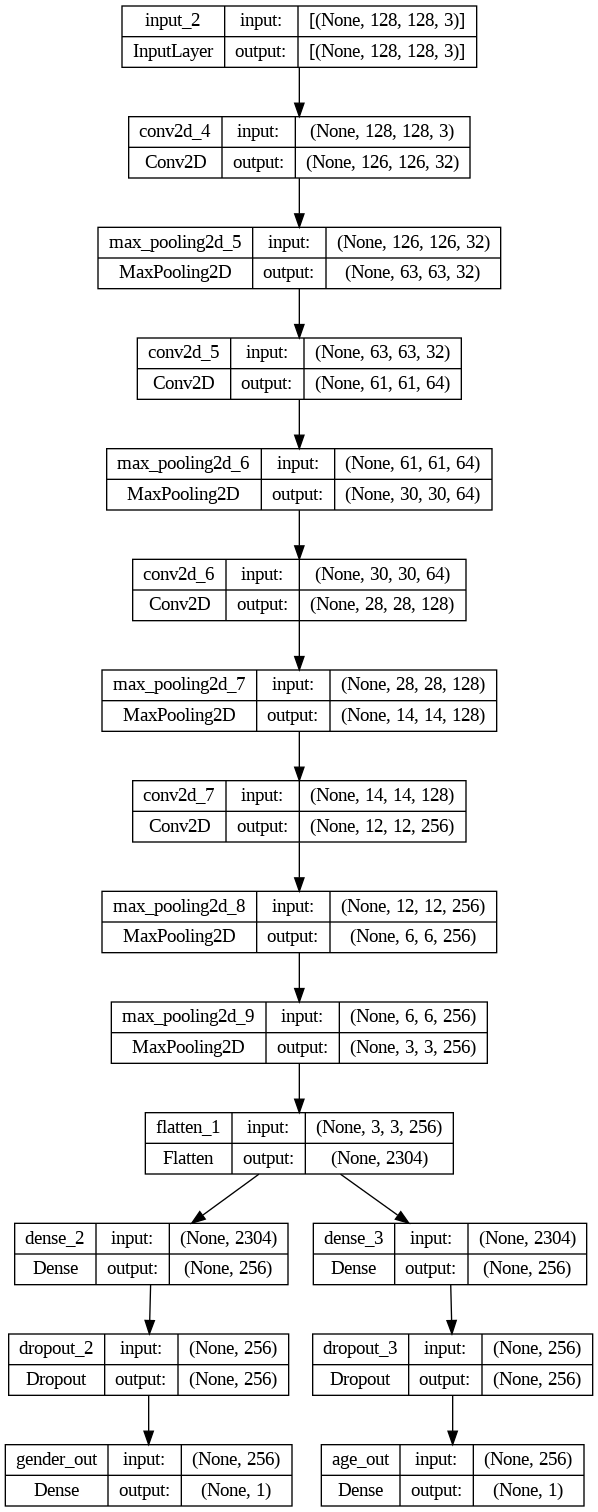

In [21]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

input_shape = (128, 128, 3)

inputs = Input((input_shape))

# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation = 'relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation = 'relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation = 'relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation = 'relu') (maxp_3)
maxp_4= MaxPooling2D(pool_size=(2,2)) (conv_4)
maxp_5 = MaxPooling2D(pool_size=(2,2)) (maxp_4)

flatten = Flatten() (maxp_5)

# fully connected layers 
dense_1 = Dense(256, activation = 'relu') (flatten)
dense_2 = Dense(256, activation = 'relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation= 'sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation= 'relu', name='age_out') (dropout_2)

modelA = Model(inputs=[inputs], outputs=[output_1, output_2])

modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)


## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [26]:
modelA.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])
modelA.save("age_gender_A.h5")

In [27]:
#train
history = modelA.fit(x=X , y=[y_gender, y_age], batch_size=32, epochs=10, validation_split=0.2)

Epoch 1/10
125/125 [==============================] - 202s 2s/step - loss: 7.2522 - gender_out_loss: 0.3202 - age_out_loss: 6.9320 - gender_out_accuracy: 0.8590 - gender_out_mae: 0.2032 - age_out_accuracy: 0.0172 - age_out_mae: 6.9320 - val_loss: 8.3278 - val_gender_out_loss: 0.3724 - val_age_out_loss: 7.9554 - val_gender_out_accuracy: 0.8240 - val_gender_out_mae: 0.2232 - val_age_out_accuracy: 0.0230 - val_age_out_mae: 7.9554
Epoch 2/10
125/125 [==============================] - 218s 2s/step - loss: 6.8392 - gender_out_loss: 0.3045 - age_out_loss: 6.5347 - gender_out_accuracy: 0.8633 - gender_out_mae: 0.1975 - age_out_accuracy: 0.0135 - age_out_mae: 6.5347 - val_loss: 8.2879 - val_gender_out_loss: 0.3437 - val_age_out_loss: 7.9442 - val_gender_out_accuracy: 0.8400 - val_gender_out_mae: 0.2198 - val_age_out_accuracy: 0.0070 - val_age_out_mae: 7.9442
Epoch 3/10
125/125 [==============================] - 195s 2s/step - loss: 6.3684 - gender_out_loss: 0.2872 - age_out_loss: 6.0812 - gende

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


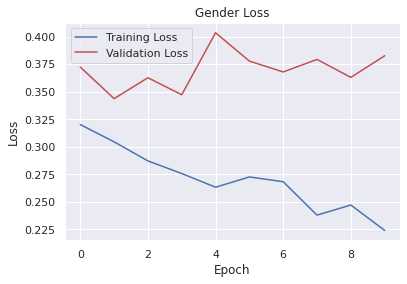

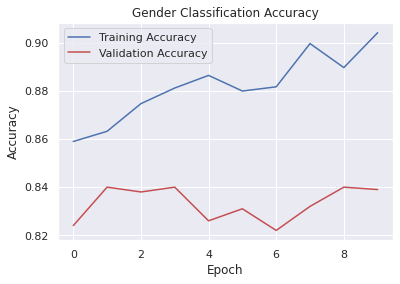

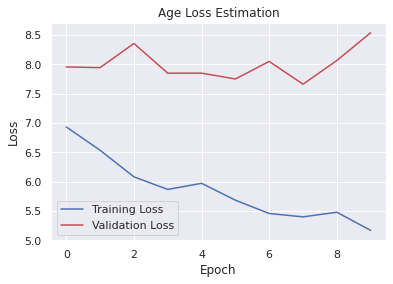

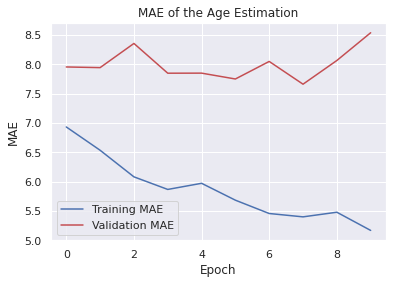

In [28]:
import matplotlib.pyplot as plt

# Gender Loss Graph
loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Gender Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Gender Classification Accuracy Graph
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Age Loss Estimation Graph
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Age Loss Estimation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Age Prediction MAE Graph
mae = history.history['age_out_mae']
val_mae = history.history['val_age_out_mae']
plt.plot(epochs, mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Validation MAE')
plt.title('MAE of the Age Estimation')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [ ]:
#
# Add your code here
#

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
#
# Add your code here
#

modelB.save(your_model_folder+"age_gender_B.h5")

NameError: ignored

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
#
# Add your code here
#


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#